<a href="https://www.kaggle.com/code/dataranch/iran-protest-tweets-xgboost-fastai-eda?scriptVersionId=107609863" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Iran Protests Tweets | Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

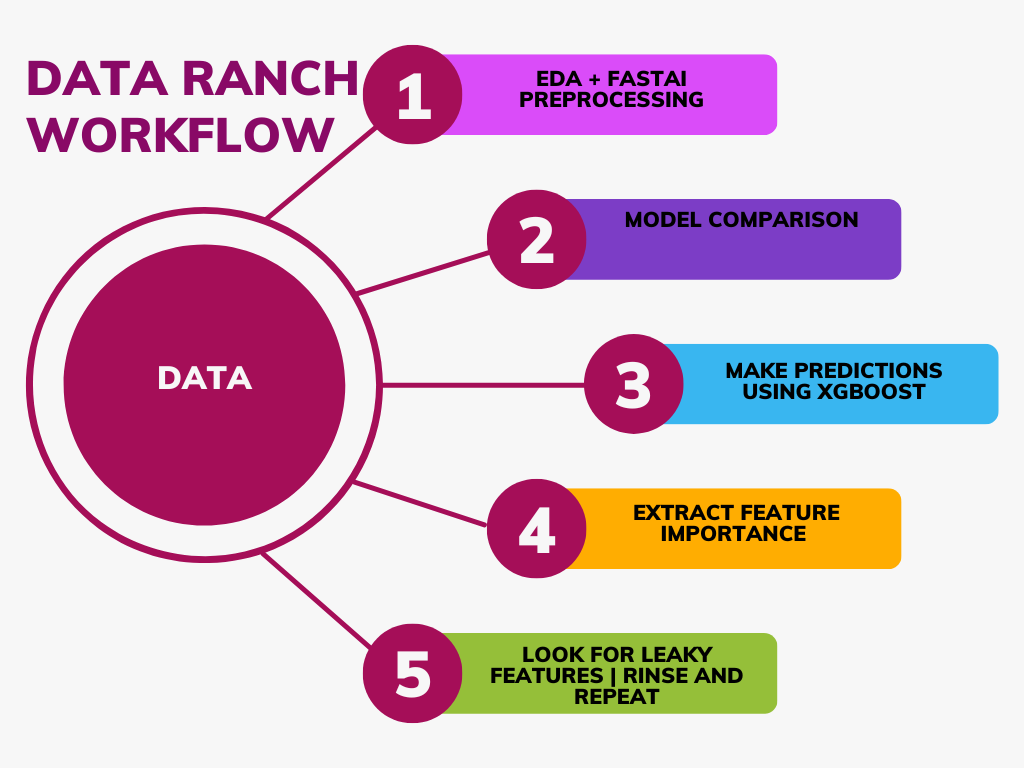

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.3 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil


In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'iran-protests-2022-tweets'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 8000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_PERCENT = False
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/iran-protests-2022-tweets
CSV!


In [12]:
df.head(1)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source
0,Saman Arbabi,NYC,"actress, singer, model, pimp and prostitute - our fatwa is bigger than yours",2010-11-23 18:48:21+00:00,113193.00,394,13460,True,2022-10-09 21:53:37+00:00,#Iranian protesters defacing Islamic Republic of #Iran’s embassy in #London #UK.\nCurrent Islamic flag replaced with pre-Islamic flag. IRI emblem at the door also vandalized. \n\n#مهسا_امینی #اعتراضات_سراسرى\n#MahsaAmini #Mahsa_Amini #IranProtests2022 #IranProtests #OpIran https://t.co/KBAASvd99I,"['Iranian', 'Iran', 'London', 'UK']",Twitter for iPhone


In [13]:
df.isna().sum()

user_name              0
user_location       3961
user_description    1872
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2577
source                 0
dtype: int64

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

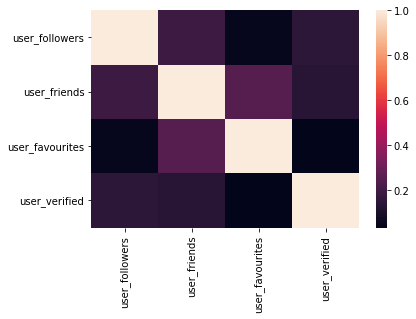

In [15]:
sns.heatmap(df.corr())

In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
user_followers,8000.00,9327.44,121012.67,0.00,20.75,172.00,1221.00,5557675.00
user_friends,8000.00,988.34,3773.56,0.00,73.00,238.00,839.25,194904.00
user_favourites,8000.00,18377.18,41793.50,0.00,712.00,3525.50,16581.00,1320239.00


In [17]:
df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source'],
      dtype='object')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**More EDA 📊**</div>

In [18]:
def get_first_hashtag(hashtag_list):
    try:
        first_hashtag = hashtag_list.strip('][').split(', ')[0].replace('.','')
    except Exception:
        first_hashtag = ''
    return first_hashtag

In [19]:
df['first_hashtag'] = df['hashtags'].apply(get_first_hashtag)

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Top 10 Hashtags**</div>

In [20]:
hashtag = df['first_hashtag'].value_counts()[:10]
fig = px.bar(x=hashtag.index,y=hashtag.values,text=hashtag.values,
       color = hashtag.index, color_discrete_sequence=px.colors.sequential.deep,
        title = 'Distribution of Top 10 Hashtags')
us,uk = [1,3,4,6],[0,2,5,8]

for idx in us:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "crimson"
for idx in uk:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "blue"
fig.show()

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Author Distribution**</div>

In [21]:
sentiment = df["user_name"].value_counts().sort_values(ascending=False).iloc[0:10]
fig = px.pie(values=sentiment.values, 
             names=sentiment.index,
             color_discrete_sequence=px.colors.sequential.Greens)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Tweeters Pie Graph",
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

In [22]:
def get_all_str(tweet):
    sentence = ''
    for words in tweet:
        sentence += words
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

def get_hashtag(text):
    result = nltk.RegexpTokenizer(r'(?<=#)\w+').tokenize(text.lower())
    return result

def get_mention(text):
    result = nltk.RegexpTokenizer(r'(?<=@)\w+').tokenize(text.lower())
    return result 

def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

def remove_stopword(stopwords, lst):    
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
#     print(stoplist)
    return cleanwordlist

def pos_remove_noun(tagged):
    remove_noun = [word for word,pos in tagged if pos not in ['NN','NNS','NNP','NNPS']]
    txt = ''
    for i in range(len(remove_noun)):
        txt += remove_noun[i]
        txt += '\n'
    return cleanwordlist

def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
#     txt= ' '.join(tokens)
    return tokens

def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=50,
               colormap= colormap,
               max_font_size=140,
               random_state=8888, 
               background_color=color_background).generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

In [23]:
# For NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [24]:
def whole_string(sent):
    all_str = get_all_str(sent)
    words = get_word(all_str)
    removed = remove_stopword(['http','https','co'],words)
    freq_df = Freq_df(removed)
    return freq_df

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Top 20 Terms**</div>

In [25]:
freq_df = whole_string(df['text'])
top_10 = freq_df[:20]

fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn, title = 'Rank of terms')

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"
    
fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

Target Variable: user_verified
CATS=====================
['user_verified', 'source']
CONTS=====================
['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'date', 'text', 'hashtags', 'first_hashtag']
13
Could not convert user_name to float.
Could not convert user_location to float.
Could not convert user_description to float.
Could not convert user_created to float.
Could not convert date to float.
Could not convert text to float.
Could not convert hashtags to float.
Could not convert first_hashtag to float.
Looping through continuous variables to find breakpoint
Error with  user_name
Error with  user_location
Error with  user_description
Error with  user_created
Error with  date
Error with  text
Error with  hashtags
Error with  first_hashtag
Continuous variables that made the cut : ['user_followers', 'user_friends', 'user_favourites']
Categorical variables that made the cut : ['user_verified', 'source']
Tabul

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.057407922079829365, 'Adjusted R-Squared': 0.056818064709416305, 'RMSE': 0.22716426317943456, 'Time taken': 0.03274035453796387}


 19%|█▉        | 8/42 [00:00<00:00, 37.01it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.06878231758672149, 'Adjusted R-Squared': 0.06819957811086841, 'RMSE': 0.22578949111941032, 'Time taken': 0.033064842224121094}
{'Model': 'BayesianRidge', 'R-Squared': 0.0025303217042368376, 'Adjusted R-Squared': 0.001906122906805252, 'RMSE': 0.23368345717520375, 'Time taken': 0.028235197067260742}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.07622969732069174, 'Adjusted R-Squared': 0.07565161828271982, 'RMSE': 0.22488480704956879, 'Time taken': 0.010097026824951172}
{'Model': 'DummyRegressor', 'R-Squared': -1.1148689627260566e-05, 'Adjusted R-Squared': -0.0006369378940638271, 'RMSE': 0.23398097086421898, 'Time taken': 0.010046720504760742}
{'Model': 'ElasticNet', 'R-Squared': -1.1148689627260566e-05, 'Adjusted R-Squared': -0.0006369378940638271, 'RMSE': 0.23398097086421898, 'Time taken': 0.011745929718017578}
{'Model': 'ElasticNetCV', 'R-Squared': 0.002431133226176607, 'Adjusted R-Squared': 0.0018068723583583024, 'RMSE': 0.2336950756387

 29%|██▊       | 12/42 [00:08<00:29,  1.01it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.07544308651381393, 'Adjusted R-Squared': 0.0748645152287788, 'RMSE': 0.22498053386453176, 'Time taken': 8.206490278244019}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.07409738888548478, 'Adjusted R-Squared': 0.07351797548678995, 'RMSE': 0.22514420452712638, 'Time taken': 0.14543676376342773}


 36%|███▌      | 15/42 [00:08<00:18,  1.45it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.056435621583291073, 'Adjusted R-Squared': 0.055845155764507215, 'RMSE': 0.22728139497063315, 'Time taken': 0.16041183471679688}
{'Model': 'HuberRegressor', 'R-Squared': -0.061712010220199565, 'Adjusted R-Squared': -0.06237641072722089, 'RMSE': 0.24109126897975797, 'Time taken': 0.05245661735534668}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.2512218963831865, 'Adjusted R-Squared': -0.2520048888089581, 'RMSE': 0.261725046566048, 'Time taken': 0.03456830978393555}


 48%|████▊     | 20/42 [00:12<00:13,  1.66it/s]

{'Model': 'KernelRidge', 'R-Squared': -20.42710493663577, 'Adjusted R-Squared': -20.440513638097993, 'RMSE': 1.0830783284763, 'Time taken': 2.964421033859253}
{'Model': 'Lars', 'R-Squared': 0.0024237840864189675, 'Adjusted R-Squared': 0.0017995186196395618, 'RMSE': 0.23369593645886208, 'Time taken': 0.02290177345275879}
{'Model': 'LarsCV', 'R-Squared': 0.0024237840864189675, 'Adjusted R-Squared': 0.0017995186196395618, 'RMSE': 0.23369593645886208, 'Time taken': 0.03551149368286133}
{'Model': 'Lasso', 'R-Squared': -1.1148689627260566e-05, 'Adjusted R-Squared': -0.0006369378940638271, 'RMSE': 0.23398097086421898, 'Time taken': 0.022011518478393555}
{'Model': 'LassoCV', 'R-Squared': 0.0024309651068531446, 'Adjusted R-Squared': 0.0018067041338287737, 'RMSE': 0.23369509533099214, 'Time taken': 0.10779690742492676}
{'Model': 'LassoLars', 'R-Squared': -1.1148689627260566e-05, 'Adjusted R-Squared': -0.0006369378940638271, 'RMSE': 0.23398097086421898, 'Time taken': 0.011622190475463867}
{'Model

 62%|██████▏   | 26/42 [00:13<00:06,  2.62it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.04279396313857664, 'Adjusted R-Squared': 0.042194960612380594, 'RMSE': 0.22891846876276628, 'Time taken': 0.8340744972229004}


 67%|██████▋   | 28/42 [00:13<00:05,  2.55it/s]

{'Model': 'NuSVR', 'R-Squared': -0.05941315743284914, 'Adjusted R-Squared': -0.06007611935865187, 'RMSE': 0.24083011827856352, 'Time taken': 0.8560066223144531}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0024237840864189675, 'Adjusted R-Squared': 0.0017995186196395618, 'RMSE': 0.23369593645886208, 'Time taken': 0.011589527130126953}
OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(6400, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.20208856633881056, 'Adjusted R-Squared': -0.2028408119998486, 'RMSE': 0.25653483762334084, 'Time taken': 0.015319347381591797}
{'Model': 'PoissonRegressor', 'R-Squared': 0.003658269882656162, 'Adjusted R-Squared': 0.003034776935148531, 'RMSE': 0.23355129406627068, 'Time taken': 0.013223886489868164}


 76%|███████▌  | 32/42 [40:01<34:59, 209.96s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.06171201061877141, 'Adjusted R-Squared': -0.062376411126042086, 'RMSE': 0.24109126902501138, 'Time taken': 2387.2208347320557}
{'Model': 'RANSACRegressor', 'R-Squared': -0.06171201061711984, 'Adjusted R-Squared': -0.06237641112438963, 'RMSE': 0.2410912690248239, 'Time taken': 0.032494544982910156}


 81%|████████  | 34/42 [40:01<22:22, 167.86s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.07250245139791855, 'Adjusted R-Squared': 0.07192203991568957, 'RMSE': 0.22533803507706962, 'Time taken': 0.23423266410827637}
{'Model': 'Ridge', 'R-Squared': 0.002424907214406802, 'Adjusted R-Squared': 0.0018006424504609653, 'RMSE': 0.2336958049047429, 'Time taken': 0.013153314590454102}
{'Model': 'RidgeCV', 'R-Squared': 0.002434978516255404, 'Adjusted R-Squared': 0.001810720054751247, 'RMSE': 0.23369462523067658, 'Time taken': 0.016438007354736328}
{'Model': 'SGDRegressor', 'R-Squared': 0.002273353928760602, 'Adjusted R-Squared': 0.001648994325462061, 'RMSE': 0.2337135559604112, 'Time taken': 0.030707359313964844}


 90%|█████████ | 38/42 [40:01<07:06, 106.74s/it]

{'Model': 'SVR', 'R-Squared': -0.04012653563973201, 'Adjusted R-Squared': -0.04077742834038256, 'RMSE': 0.23862789260986125, 'Time taken': 0.42086243629455566}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.0024237840864189675, 'Adjusted R-Squared': 0.0017995186196395618, 'RMSE': 0.23369593645886208, 'Time taken': 0.01339578628540039}
{'Model': 'TweedieRegressor', 'R-Squared': 0.0036127123956216645, 'Adjusted R-Squared': 0.0029891909390482585, 'RMSE': 0.23355663354373332, 'Time taken': 0.013985395431518555}


100%|██████████| 42/42 [40:02<00:00, 57.20s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.07621591972516395, 'Adjusted R-Squared': 0.07563783206541752, 'RMSE': 0.22488649, 'Time taken': 0.5080969333648682}
{'Model': 'LGBMRegressor', 'R-Squared': 0.05173288621309646, 'Adjusted R-Squared': 0.05113947750609593, 'RMSE': 0.22784707750651767, 'Time taken': 0.10094857215881348}
Project: iran-protests-2022-tweets
iran-protests-2022-tweets
Target: user_verified
user_verified
Target Standard Deviation: 0.23249826738265703
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.08       0.08  0.22        0.16
DecisionTreeRegressor                        0.08       0.08  0.22        0.01
ExtraTreeRegressor                           0.08       0.08  0.22        0.01
XGBRegressor                                 0.08       0.08  0.22        0.51
GaussianProcessRegressor                     0.07       0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,2.214823,0.119268,0.345352,00:04
1,0.648224,0.158355,0.397939,00:04


Better model found at epoch 0 with _rmse value: 0.3453517556190491.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.05
1       1       1.14
2       1       1.14
3       1       1.01
4       1       1.14
XGBoost RMSE:  0.22488649


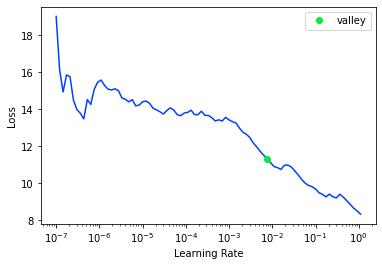

<Figure size 720x720 with 0 Axes>

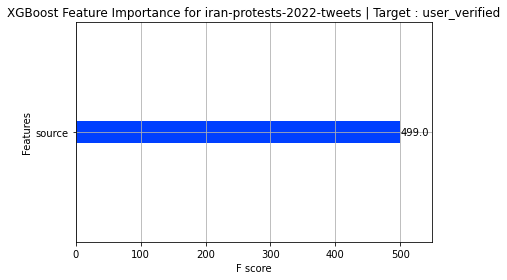

Target Variable: user_favourites
CATS=====================
['user_verified', 'source']
CONTS=====================
['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'date', 'text', 'hashtags', 'first_hashtag']
12
Could not convert user_name to float.
Could not convert user_location to float.
Could not convert user_description to float.
Could not convert user_created to float.
Could not convert date to float.
Could not convert text to float.
Could not convert hashtags to float.
Could not convert first_hashtag to float.
Looping through continuous variables to find breakpoint
Error with  user_name
Error with  user_location
Error with  user_description
Error with  user_created
Error with  date
Error with  text
Error with  hashtags
Error with  first_hashtag
Continuous variables that made the cut : ['user_followers', 'user_friends']
Categorical variables that made the cut : ['user_verified', 'source']
Tabular Object size: 8000


  7%|▋         | 3/42 [00:00<00:01, 21.43it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.02423112920100834, 'Adjusted R-Squared': 0.023009126858116735, 'RMSE': 38517.16384383149, 'Time taken': 0.03358650207519531}
{'Model': 'BaggingRegressor', 'R-Squared': 0.025631330648776318, 'Adjusted R-Squared': 0.024411081845581384, 'RMSE': 38489.51838815831, 'Time taken': 0.04601907730102539}
{'Model': 'BayesianRidge', 'R-Squared': 0.004822114107700504, 'Adjusted R-Squared': 0.0035758049206093823, 'RMSE': 38898.35001771101, 'Time taken': 0.05971240997314453}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.02606886269383346, 'Adjusted R-Squared': 0.02484916183308694, 'RMSE': 38480.87572077907, 'Time taken': 0.03154611587524414}
{'Model': 'DummyRegressor', 'R-Squared': -5.906918787768056e-05, 'Adjusted R-Squared': -0.0013114913158525088, 'RMSE': 38993.63, 'Time taken': 0.022996187210083008}


 14%|█▍        | 6/42 [00:00<00:01, 25.53it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.0040542620605715785, 'Adjusted R-Squared': 0.0028069912553876364, 'RMSE': 38913.35357585305, 'Time taken': 0.04212808609008789}
{'Model': 'ElasticNetCV', 'R-Squared': 0.002509916823552061, 'Adjusted R-Squared': 0.00126071196046329, 'RMSE': 38943.51203301026, 'Time taken': 0.2330930233001709}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.0260122305792031, 'Adjusted R-Squared': 0.024792458795332428, 'RMSE': 38481.994496841646, 'Time taken': 0.022446393966674805}


 21%|██▏       | 9/42 [00:00<00:03, 10.41it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.025944474211855417, 'Adjusted R-Squared': 0.024724617573423258, 'RMSE': 38483.33299147796, 'Time taken': 0.232072114944458}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 29%|██▊       | 12/42 [00:11<00:43,  1.46s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.026506008881139298, 'Adjusted R-Squared': 0.025286855479612957, 'RMSE': 38472.23873635307, 'Time taken': 11.019456148147583}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.02613619986457516, 'Adjusted R-Squared': 0.02491658333340996, 'RMSE': 38479.54542236808, 'Time taken': 0.16451787948608398}


 33%|███▎      | 14/42 [00:12<00:28,  1.02s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.02302289753289144, 'Adjusted R-Squared': 0.02179938206330212, 'RMSE': 38541.003126514974, 'Time taken': 0.2342829704284668}
{'Model': 'HuberRegressor', 'R-Squared': -0.09631374199413978, 'Adjusted R-Squared': -0.09768670848380046, 'RMSE': 40827.073478026345, 'Time taken': 0.07428884506225586}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.6290967252929853, 'Adjusted R-Squared': -0.6311369215676164, 'RMSE': 49768.47, 'Time taken': 0.1163034439086914}


 45%|████▌     | 19/42 [00:16<00:18,  1.21it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.22550336553250228, 'Adjusted R-Squared': -0.22703812240856047, 'RMSE': 43165.62918467592, 'Time taken': 4.038313627243042}
{'Model': 'Lars', 'R-Squared': 0.00544026023234212, 'Adjusted R-Squared': 0.004194725179408332, 'RMSE': 38886.26745456618, 'Time taken': 0.021725893020629883}
{'Model': 'LarsCV', 'R-Squared': 0.00544026023234212, 'Adjusted R-Squared': 0.004194725179408332, 'RMSE': 38886.26745456618, 'Time taken': 0.0413975715637207}
{'Model': 'Lasso', 'R-Squared': 0.005436181531308537, 'Adjusted R-Squared': 0.004190641370421022, 'RMSE': 38886.34719100146, 'Time taken': 0.0520327091217041}


 60%|█████▉    | 25/42 [00:16<00:06,  2.72it/s]

{'Model': 'LassoCV', 'R-Squared': 0.005432220083068429, 'Adjusted R-Squared': 0.004186674961068615, 'RMSE': 38886.4246350505, 'Time taken': 0.26790380477905273}
{'Model': 'LassoLars', 'R-Squared': 0.005103220881672477, 'Adjusted R-Squared': 0.0038572637381304453, 'RMSE': 38892.855843191704, 'Time taken': 0.059258222579956055}
{'Model': 'LassoLarsCV', 'R-Squared': 0.00544026023234212, 'Adjusted R-Squared': 0.004194725179408332, 'RMSE': 38886.26745456618, 'Time taken': 0.04808402061462402}
{'Model': 'LassoLarsIC', 'R-Squared': 0.00544026023234212, 'Adjusted R-Squared': 0.004194725179408332, 'RMSE': 38886.26745456618, 'Time taken': 0.024959564208984375}
{'Model': 'LinearRegression', 'R-Squared': 0.00544026023234212, 'Adjusted R-Squared': 0.004194725179408332, 'RMSE': 38886.26745456618, 'Time taken': 0.0214231014251709}
{'Model': 'LinearSVR', 'R-Squared': -0.18714338343878767, 'Adjusted R-Squared': -0.18863010026212979, 'RMSE': 42484.68569071048, 'Time taken': 0.023264169692993164}
{'Model

 74%|███████▍  | 31/42 [00:28<00:10,  1.04it/s]

{'Model': 'NuSVR', 'R-Squared': -0.06593168222698731, 'Adjusted R-Squared': -0.06726659980022087, 'RMSE': 40257.37997988137, 'Time taken': 2.022655487060547}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0015235883808517592, 'Adjusted R-Squared': 0.0002731482911597638, 'RMSE': 38962.76114816193, 'Time taken': 0.013373374938964844}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.00544026023234212, 'Adjusted R-Squared': 0.004194725179408332, 'RMSE': 38886.26745456618, 'Time taken': 0.032262325286865234}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.1325311321006648, 'Adjusted R-Squared': -0.13394945537192426, 'RMSE': 41495.96761403332, 'Time taken': 0.04170489311218262}
{'Model': 'PoissonRegressor', 'R-Squared': 0.0058751226715940685, 'Adjusted R-Squared': 0.004630132217832816, 'RMSE': 38877.765187028606, 'Time taken': 0.037372589111328125}


 76%|███████▌  | 32/42 [1:48:48<2:17:58, 827.84s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.1508920785103609, 'Adjusted R-Squared': -0.15233339607893992, 'RMSE': 41830.98796645211, 'Time taken': 6500.523744106293}
{'Model': 'RANSACRegressor', 'R-Squared': -0.19004221524586784, 'Adjusted R-Squared': -0.1915325624158688, 'RMSE': 42536.52478164102, 'Time taken': 0.08428168296813965}


 81%|████████  | 34/42 [1:48:49<1:20:57, 607.21s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.025589597711836554, 'Adjusted R-Squared': 0.02436929664447507, 'RMSE': 38490.34264672443, 'Time taken': 0.3255937099456787}
{'Model': 'Ridge', 'R-Squared': 0.005439735797622358, 'Adjusted R-Squared': 0.004194200087913713, 'RMSE': 38886.277706995104, 'Time taken': 0.012544870376586914}
{'Model': 'RidgeCV', 'R-Squared': 0.005435017697918876, 'Adjusted R-Squared': 0.004189476079506815, 'RMSE': 38886.369943295074, 'Time taken': 0.01894688606262207}
{'Model': 'SGDRegressor', 'R-Squared': 0.00678538376940907, 'Adjusted R-Squared': 0.005541533279452282, 'RMSE': 38859.96208068844, 'Time taken': 0.0434727668762207}


 90%|█████████ | 38/42 [1:48:52<23:00, 345.01s/it]  

{'Model': 'SVR', 'R-Squared': -0.1504794696306353, 'Adjusted R-Squared': -0.15192027046924594, 'RMSE': 41823.488833975665, 'Time taken': 3.0222885608673096}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.00544026023234212, 'Adjusted R-Squared': 0.004194725179408332, 'RMSE': 38886.26745456618, 'Time taken': 0.014015674591064453}
{'Model': 'TweedieRegressor', 'R-Squared': 0.0031816716740621365, 'Adjusted R-Squared': 0.0019333080819194937, 'RMSE': 38930.3966650265, 'Time taken': 0.022608041763305664}


100%|██████████| 42/42 [1:48:52<00:00, 155.54s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.02580116742536187, 'Adjusted R-Squared': 0.024581131316940397, 'RMSE': 38486.164, 'Time taken': 0.606950044631958}
{'Model': 'LGBMRegressor', 'R-Squared': 0.022989142316579336, 'Adjusted R-Squared': 0.021765584573707253, 'RMSE': 38541.668929560445, 'Time taken': 0.06723165512084961}
Project: iran-protests-2022-tweets
iran-protests-2022-tweets
Target: user_favourites
user_favourites
Target Standard Deviation: 42461.4765625
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GaussianProcessRegressor                     0.03       0.03 38472.24   
GradientBoostingRegressor                    0.02       0.03 38479.55   
DecisionTreeRegressor                        0.02       0.03 38480.88   
ExtraTreeRegressor                           0.02       0.03 38481.99   
ExtraTreesRegressor                          0.02       0.03 38483.33   
XGBRegressor          

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,2070979456.000000,1862864256.000000,43160.910156,00:05
1,2222073088.000000,1658070528.000000,40719.414062,00:04
2,2044921728.000000,1532997504.000000,39153.511719,00:04
3,1735203328.000000,1516613504.000000,38943.722656,00:04
4,1787097856.000000,1526152064.000000,39065.996094,00:04


Better model found at epoch 0 with _rmse value: 43160.91015625.
Better model found at epoch 1 with _rmse value: 40719.4140625.
Better model found at epoch 2 with _rmse value: 39153.51171875.
Better model found at epoch 3 with _rmse value: 38943.72265625.
No improvement since epoch 3: early stopping


,user_verified,source,user_favourites,user_favourites_pred
0,1.00,26.00,4660.00,14035.96
1,1.00,26.00,10787.00,14035.96
2,1.00,3.00,826.00,15777.50
3,1.00,26.00,285.00,14035.96
4,1.00,26.00,933.00,14035.96
5,1.00,29.00,8439.00,23259.55
6,1.00,29.00,5886.00,23259.55
7,1.00,26.00,5444.00,14035.96
8,1.00,26.00,2045.00,14035.96


<Figure size 432x288 with 0 Axes>

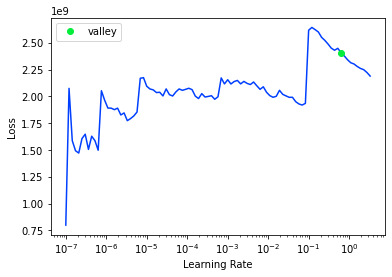

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   50.00   14553.62
1  242.00   14553.62
2 1914.00   19760.59
3   13.00   19760.59
4 3105.00   19760.59
XGBoost RMSE:  38486.164


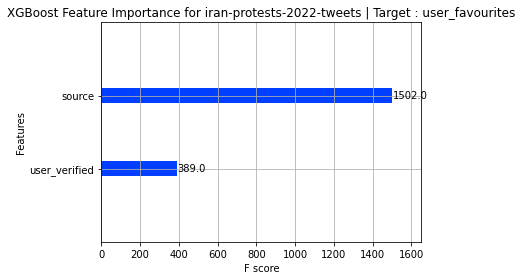

Target Variable: user_friends
CATS=====================
['user_verified', 'source']
CONTS=====================
['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_favourites', 'date', 'text', 'hashtags', 'first_hashtag']
12
Could not convert user_name to float.
Could not convert user_location to float.
Could not convert user_description to float.
Could not convert user_created to float.
Could not convert date to float.
Could not convert text to float.
Could not convert hashtags to float.
Could not convert first_hashtag to float.
Looping through continuous variables to find breakpoint
Error with  user_name
Error with  user_location
Error with  user_description
Error with  user_created
Error with  date
Error with  text
Error with  hashtags
Error with  first_hashtag
Continuous variables that made the cut : ['user_followers', 'user_favourites']
Categorical variables that made the cut : ['user_verified', 'source']
Tabular Object size: 8000


 10%|▉         | 4/42 [00:00<00:00, 38.24it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.03187521070545052, 'Adjusted R-Squared': -0.033167477719483474, 'RMSE': 3526.6959450137774, 'Time taken': 0.025795459747314453}
{'Model': 'BaggingRegressor', 'R-Squared': 0.0236994781243548, 'Adjusted R-Squared': 0.022476809969219413, 'RMSE': 3430.4112627573827, 'Time taken': 0.03539013862609863}
{'Model': 'BayesianRidge', 'R-Squared': -0.003925050614907111, 'Adjusted R-Squared': -0.005182314297580648, 'RMSE': 3478.604660041863, 'Time taken': 0.019181251525878906}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.014149112591051227, 'Adjusted R-Squared': 0.012914484053281772, 'RMSE': 3447.1489116345883, 'Time taken': 0.02381277084350586}
{'Model': 'DummyRegressor', 'R-Squared': -2.0742764557102333e-06, 'Adjusted R-Squared': -0.0012544250269583834, 'RMSE': 3471.8015, 'Time taken': 0.02212238311767578}
{'Model': 'ElasticNet', 'R-Squared': 0.002916301734225746, 'Adjusted R-Squared': 0.0016676058065291377, 'RMSE': 3466.7317403505754, 'Time tak

 19%|█▉        | 8/42 [00:00<00:01, 19.36it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.0033168154533727012, 'Adjusted R-Squared': 0.0020686211082924233, 'RMSE': 3466.035403079517, 'Time taken': 0.19480657577514648}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.012757742381472204, 'Adjusted R-Squared': 0.011521371363790944, 'RMSE': 3449.5806025070183, 'Time taken': 0.0229034423828125}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.014222292983234852, 'Adjusted R-Squared': 0.012987756092794345, 'RMSE': 3447.0209671380667, 'Time taken': 0.2212066650390625}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 29%|██▊       | 12/42 [00:11<00:35,  1.19s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -293.18308220760235, 'Adjusted R-Squared': -293.55150184718605, 'RMSE': 59547.46471457141, 'Time taken': 10.242644309997559}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.01657711932559458, 'Adjusted R-Squared': 0.015345531497574116, 'RMSE': 3442.901382635658, 'Time taken': 0.17133617401123047}


 33%|███▎      | 14/42 [00:11<00:24,  1.15it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.008050352779567449, 'Adjusted R-Squared': 0.006808086471213781, 'RMSE': 3457.7950040545816, 'Time taken': 0.21569418907165527}
{'Model': 'HuberRegressor', 'R-Squared': -0.030551697022668245, 'Adjusted R-Squared': -0.031842306536785436, 'RMSE': 3524.433497015884, 'Time taken': 0.05593252182006836}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.03754600048902601, 'Adjusted R-Squared': -0.03884536930616944, 'RMSE': 3536.373, 'Time taken': 0.10226869583129883}


 38%|███▊      | 16/42 [00:14<00:29,  1.13s/it]

{'Model': 'KernelRidge', 'R-Squared': -0.08749108452011334, 'Adjusted R-Squared': -0.08885300197098389, 'RMSE': 3620.489409428475, 'Time taken': 3.3588736057281494}
{'Model': 'Lars', 'R-Squared': -0.004324872259251267, 'Adjusted R-Squared': -0.005582636657822659, 'RMSE': 3479.2972829549567, 'Time taken': 0.023725271224975586}
{'Model': 'LarsCV', 'R-Squared': -0.004324872259251267, 'Adjusted R-Squared': -0.005582636657822659, 'RMSE': 3479.2972829549567, 'Time taken': 0.046939849853515625}
{'Model': 'Lasso', 'R-Squared': -0.00425519990297718, 'Adjusted R-Squared': -0.005512877047501918, 'RMSE': 3479.1765973825513, 'Time taken': 0.025137662887573242}


 55%|█████▍    | 23/42 [00:15<00:08,  2.29it/s]

{'Model': 'LassoCV', 'R-Squared': -0.0019359913178982335, 'Adjusted R-Squared': -0.0031907640058355113, 'RMSE': 3475.1569018983555, 'Time taken': 0.19212913513183594}
{'Model': 'LassoLars', 'R-Squared': -0.00018484810018382092, 'Adjusted R-Squared': -0.0014374277471469465, 'RMSE': 3472.118704441237, 'Time taken': 0.024676799774169922}
{'Model': 'LassoLarsCV', 'R-Squared': -0.004324872259251267, 'Adjusted R-Squared': -0.005582636657822659, 'RMSE': 3479.2972829549567, 'Time taken': 0.04351210594177246}
{'Model': 'LassoLarsIC', 'R-Squared': -0.00162106628794767, 'Adjusted R-Squared': -0.0028754445801053574, 'RMSE': 3474.610709370836, 'Time taken': 0.0263063907623291}
{'Model': 'LinearRegression', 'R-Squared': -0.004324872259251267, 'Adjusted R-Squared': -0.005582636657822659, 'RMSE': 3479.2972829549567, 'Time taken': 0.022792816162109375}
{'Model': 'LinearSVR', 'R-Squared': -0.04482253162524552, 'Adjusted R-Squared': -0.04613101319271595, 'RMSE': 3548.752354121697, 'Time taken': 0.0270090

 62%|██████▏   | 26/42 [00:24<00:20,  1.27s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.003526491235250173, 'Adjusted R-Squared': 0.0022785594772480877, 'RMSE': 3465.6708028131748, 'Time taken': 9.02599048614502}


 71%|███████▏  | 30/42 [00:26<00:11,  1.09it/s]

{'Model': 'NuSVR', 'R-Squared': -0.02185632815176919, 'Adjusted R-Squared': -0.023136048036743073, 'RMSE': 3509.5331438018993, 'Time taken': 1.9677252769470215}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.0036341050210131343, 'Adjusted R-Squared': -0.00489100433850953, 'RMSE': 3478.1005596429704, 'Time taken': 0.012416839599609375}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.0036341050210131343, 'Adjusted R-Squared': -0.00489100433850953, 'RMSE': 3478.1005596429704, 'Time taken': 0.055207014083862305}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.038910636396843445, 'Adjusted R-Squared': -0.04021171421324521, 'RMSE': 3538.69819985807, 'Time taken': 0.061608076095581055}
{'Model': 'PoissonRegressor', 'R-Squared': -0.003409143267883774, 'Adjusted R-Squared': -0.004665760854944301, 'RMSE': 3477.7107345832874, 'Time taken': 0.04204511642456055}


 76%|███████▌  | 32/42 [1:37:11<2:07:52, 767.24s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.045852031022878714, 'Adjusted R-Squared': -0.04716180188201813, 'RMSE': 3550.5002772277726, 'Time taken': 5804.680345535278}
{'Model': 'RANSACRegressor', 'R-Squared': -0.06375389885832972, 'Adjusted R-Squared': -0.06508608908858426, 'RMSE': 3580.7583329316326, 'Time taken': 0.05407309532165527}


 81%|████████  | 34/42 [1:37:11<1:14:16, 557.11s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.030055844051728564, 'Adjusted R-Squared': 0.028841136279720736, 'RMSE': 3419.2258972026125, 'Time taken': 0.30118370056152344}
{'Model': 'Ridge', 'R-Squared': -0.004320046694016977, 'Adjusted R-Squared': -0.005577805049300499, 'RMSE': 3479.2889243069535, 'Time taken': 0.013068199157714844}
{'Model': 'RidgeCV', 'R-Squared': -0.004276746616704408, 'Adjusted R-Squared': -0.005534450745216191, 'RMSE': 3479.213920774086, 'Time taken': 0.0175015926361084}
{'Model': 'SGDRegressor', 'R-Squared': -0.004642353355936768, 'Adjusted R-Squared': -0.005900515351373148, 'RMSE': 3479.84716669559, 'Time taken': 0.03446841239929199}


 90%|█████████ | 38/42 [1:37:14<20:51, 312.85s/it]  

{'Model': 'SVR', 'R-Squared': -0.043037505343246796, 'Adjusted R-Squared': -0.044343751436350276, 'RMSE': 3545.719626584318, 'Time taken': 3.0828490257263184}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.004324872259251267, 'Adjusted R-Squared': -0.005582636657822659, 'RMSE': 3479.2972829549567, 'Time taken': 0.013931989669799805}
{'Model': 'TweedieRegressor', 'R-Squared': 0.004303578258623042, 'Adjusted R-Squared': 0.0030566196841191884, 'RMSE': 3464.3192099010025, 'Time taken': 0.014601469039916992}


100%|██████████| 42/42 [1:37:15<00:00, 138.93s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.01268155827706896, 'Adjusted R-Squared': 0.011445091850365241, 'RMSE': 3449.7139, 'Time taken': 0.5792369842529297}
{'Model': 'LGBMRegressor', 'R-Squared': 0.008236684122412075, 'Adjusted R-Squared': 0.0069946511657714705, 'RMSE': 3457.4702265582, 'Time taken': 0.06226921081542969}
Project: iran-protests-2022-tweets
iran-protests-2022-tweets
Target: user_friends
user_friends
Target Standard Deviation: 3845.01513671875
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
RandomForestRegressor                        0.03       0.03  3419.23   
BaggingRegressor                             0.02       0.02  3430.41   
GradientBoostingRegressor                    0.02       0.02  3442.90   
ExtraTreesRegressor                          0.01       0.01  3447.02   
DecisionTreeRegressor                        0.01       0.01  3447.15   
ExtraTreeRegressor        

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,19896326.000000,12821112.000000,3580.657959,00:04
1,11062346.000000,11928664.000000,3453.789795,00:04
2,14137965.000000,11793485.000000,3434.164307,00:04
3,18227276.000000,12260955.000000,3501.564697,00:04


Better model found at epoch 0 with _rmse value: 3580.657958984375.
Better model found at epoch 1 with _rmse value: 3453.789794921875.
Better model found at epoch 2 with _rmse value: 3434.164306640625.
No improvement since epoch 2: early stopping


,user_verified,source,user_friends,user_friends_pred
0,1.00,25.00,746.00,1237.22
1,1.00,25.00,469.00,1237.22
2,1.00,29.00,3272.00,697.39
3,1.00,26.00,22.00,731.38
4,1.00,29.00,117.00,697.39
5,1.00,29.00,110.00,697.39
6,1.00,29.00,179.00,697.39
7,1.00,26.00,110.00,731.38
8,1.00,29.00,30.00,697.39


<Figure size 432x288 with 0 Axes>

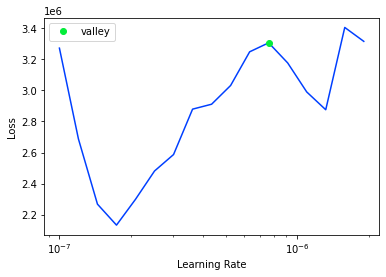

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  166.00     750.26
1    2.00     639.27
2    4.00     750.26
3  378.00     750.26
4  242.00     639.27
XGBoost RMSE:  3449.7139


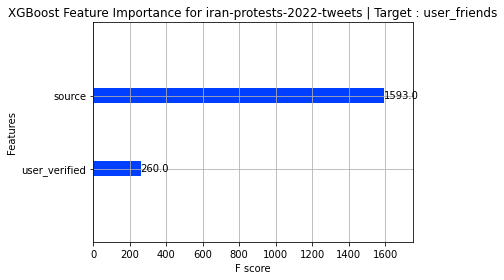

Target Variable: user_followers
CATS=====================
['user_verified', 'source']
CONTS=====================
['user_name', 'user_location', 'user_description', 'user_created', 'user_friends', 'user_favourites', 'date', 'text', 'hashtags', 'first_hashtag']
12
Could not convert user_name to float.
Could not convert user_location to float.
Could not convert user_description to float.
Could not convert user_created to float.
Could not convert date to float.
Could not convert text to float.
Could not convert hashtags to float.
Could not convert first_hashtag to float.
Looping through continuous variables to find breakpoint
Error with  user_name
Error with  user_location
Error with  user_description
Error with  user_created
Error with  date
Error with  text
Error with  hashtags
Error with  first_hashtag
Continuous variables that made the cut : ['user_friends', 'user_favourites']
Categorical variables that made the cut : ['user_verified', 'source']
Tabular Object size: 8000


 10%|▉         | 4/42 [00:00<00:01, 35.13it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.028923725628726693, 'Adjusted R-Squared': -0.030212296355875967, 'RMSE': 246511.52012708446, 'Time taken': 0.0347592830657959}
{'Model': 'BaggingRegressor', 'R-Squared': -0.008063725352818185, 'Adjusted R-Squared': -0.009326172097154695, 'RMSE': 243999.88552520654, 'Time taken': 0.03553509712219238}
{'Model': 'BayesianRidge', 'R-Squared': 0.002497351601622566, 'Adjusted R-Squared': 0.0012481310025013181, 'RMSE': 242718.37604299234, 'Time taken': 0.01860332489013672}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.0007202302386475345, 'Adjusted R-Squared': -0.0019734803704429815, 'RMSE': 243109.52160812376, 'Time taken': 0.02452373504638672}
{'Model': 'DummyRegressor', 'R-Squared': -0.0018029580384284483, 'Adjusted R-Squared': -0.0030575641223837824, 'RMSE': 243240.98, 'Time taken': 0.021678924560546875}
{'Model': 'ElasticNet', 'R-Squared': 0.002440576863972921, 'Adjusted R-Squared': 0.0011912851631138421, 'RMSE': 242725.2833309418, 'Tim

 19%|█▉        | 8/42 [00:00<00:01, 18.19it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.0012742726247998437, 'Adjusted R-Squared': -0.002528216610554024, 'RMSE': 243176.81031557664, 'Time taken': 0.2204732894897461}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.0007202302386475345, 'Adjusted R-Squared': -0.0019734803704429815, 'RMSE': 243109.52160812376, 'Time taken': 0.023859262466430664}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.0007202044198335589, 'Adjusted R-Squared': -0.0019734545192948705, 'RMSE': 243109.51847198274, 'Time taken': 0.21419978141784668}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 29%|██▊       | 12/42 [00:11<00:37,  1.24s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.001084021299732063, 'Adjusted R-Squared': -0.0023377270245907855, 'RMSE': 243153.70630224972, 'Time taken': 10.679542541503906}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.0006402368778259948, 'Adjusted R-Squared': -0.0018933868300836654, 'RMSE': 243099.8048382715, 'Time taken': 0.16777563095092773}


 33%|███▎      | 14/42 [00:11<00:25,  1.11it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.0006367473546926572, 'Adjusted R-Squared': -0.0018898929368524886, 'RMSE': 243099.38095808908, 'Time taken': 0.1956954002380371}
{'Model': 'HuberRegressor', 'R-Squared': -0.002247083570930064, 'Adjusted R-Squared': -0.003502245854675623, 'RMSE': 243294.9136351324, 'Time taken': 0.07686090469360352}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.0017989638546695996, 'Adjusted R-Squared': -0.0030535649365164286, 'RMSE': 243240.52, 'Time taken': 0.10050225257873535}


 38%|███▊      | 16/42 [00:15<00:32,  1.25s/it]

{'Model': 'KernelRidge', 'R-Squared': -0.0009375222048988441, 'Adjusted R-Squared': -0.002191044461886671, 'RMSE': 243135.91403884144, 'Time taken': 3.951432704925537}
{'Model': 'Lars', 'R-Squared': 0.0024919494732642544, 'Adjusted R-Squared': 0.0012427221087975004, 'RMSE': 242719.0332813712, 'Time taken': 0.022067785263061523}
{'Model': 'LarsCV', 'R-Squared': 0.0024919494732642544, 'Adjusted R-Squared': 0.0012427221087975004, 'RMSE': 242719.0332813712, 'Time taken': 0.044419050216674805}
{'Model': 'Lasso', 'R-Squared': 0.002491862763988273, 'Adjusted R-Squared': 0.001242635290931382, 'RMSE': 242719.04383065508, 'Time taken': 0.021480798721313477}


 55%|█████▍    | 23/42 [00:16<00:09,  2.09it/s]

{'Model': 'LassoCV', 'R-Squared': 0.002423432582073004, 'Adjusted R-Squared': 0.0011741194106041908, 'RMSE': 242727.36908779287, 'Time taken': 0.19351816177368164}
{'Model': 'LassoLars', 'R-Squared': 0.0024848971639293005, 'Adjusted R-Squared': 0.001235660967516039, 'RMSE': 242719.89128280678, 'Time taken': 0.03614211082458496}
{'Model': 'LassoLarsCV', 'R-Squared': 0.0024919494732642544, 'Adjusted R-Squared': 0.0012427221087975004, 'RMSE': 242719.0332813712, 'Time taken': 0.039501190185546875}
{'Model': 'LassoLarsIC', 'R-Squared': 0.0024919494732642544, 'Adjusted R-Squared': 0.0012427221087975004, 'RMSE': 242719.0332813712, 'Time taken': 0.03440570831298828}
{'Model': 'LinearRegression', 'R-Squared': 0.0024919494732642544, 'Adjusted R-Squared': 0.0012427221087975004, 'RMSE': 242719.0332813712, 'Time taken': 0.02052783966064453}
{'Model': 'LinearSVR', 'R-Squared': -0.004278501513223176, 'Adjusted R-Squared': -0.0055362078394762815, 'RMSE': 243541.35160356175, 'Time taken': 0.02426242828

 62%|██████▏   | 26/42 [00:24<00:19,  1.24s/it]

{'Model': 'MLPRegressor', 'R-Squared': -0.0018347674931991076, 'Adjusted R-Squared': -0.0030894134136663087, 'RMSE': 243244.86373954467, 'Time taken': 8.46559739112854}


 74%|███████▍  | 31/42 [00:26<00:08,  1.26it/s]

{'Model': 'NuSVR', 'R-Squared': -0.004771244629711013, 'Adjusted R-Squared': -0.006029568041896027, 'RMSE': 243601.09031562586, 'Time taken': 1.9582552909851074}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0022210177295394207, 'Adjusted R-Squared': 0.000971451064203932, 'RMSE': 242751.99332927703, 'Time taken': 0.01093745231628418}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.0022210177295394207, 'Adjusted R-Squared': 0.000971451064203932, 'RMSE': 242751.99332927703, 'Time taken': 0.03095245361328125}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.002315089887854782, 'Adjusted R-Squared': -0.0035703373391857696, 'RMSE': 243303.16774263396, 'Time taken': 0.032659292221069336}
{'Model': 'PoissonRegressor', 'R-Squared': 0.002186414644406609, 'Adjusted R-Squared': 0.0009368046439613975, 'RMSE': 242756.2026257314, 'Time taken': 0.04264640808105469}


 76%|███████▌  | 32/42 [1:45:52<2:25:05, 870.58s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.005132046084868946, 'Adjusted R-Squared': -0.006390821346089703, 'RMSE': 243644.82352332826, 'Time taken': 6326.1534106731415}
{'Model': 'RANSACRegressor', 'R-Squared': -0.0012436385801759542, 'Adjusted R-Squared': -0.002497544201440993, 'RMSE': 243173.0902827931, 'Time taken': 0.08912348747253418}


 81%|████████  | 34/42 [1:45:53<1:23:20, 625.07s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.002867826985049282, 'Adjusted R-Squared': -0.0041237666556628305, 'RMSE': 243370.24452950153, 'Time taken': 0.28343963623046875}
{'Model': 'Ridge', 'R-Squared': 0.0024922422899528174, 'Adjusted R-Squared': 0.0012430152921945048, 'RMSE': 242718.99765650142, 'Time taken': 0.012360811233520508}
{'Model': 'RidgeCV', 'R-Squared': 0.0024948601826578765, 'Adjusted R-Squared': 0.0012456364634126915, 'RMSE': 242718.6791563668, 'Time taken': 0.016759395599365234}
{'Model': 'SGDRegressor', 'R-Squared': 0.0020601433091164134, 'Adjusted R-Squared': 0.000810375172997646, 'RMSE': 242771.56229841622, 'Time taken': 0.042151689529418945}


 90%|█████████ | 38/42 [1:45:56<23:05, 346.48s/it]  

{'Model': 'SVR', 'R-Squared': -0.005027438336075329, 'Adjusted R-Squared': -0.006286082591975273, 'RMSE': 243632.1446918441, 'Time taken': 3.094165563583374}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.0024919494732642544, 'Adjusted R-Squared': 0.0012427221087975004, 'RMSE': 242719.0332813712, 'Time taken': 0.013498306274414062}
{'Model': 'TweedieRegressor', 'R-Squared': 0.0019056011000545547, 'Adjusted R-Squared': 0.0006556394232857254, 'RMSE': 242790.35952394907, 'Time taken': 0.023180246353149414}


100%|██████████| 42/42 [1:45:57<00:00, 151.36s/it]

{'Model': 'XGBRegressor', 'R-Squared': -0.0007203009973364427, 'Adjusted R-Squared': -0.001973551217746339, 'RMSE': 243109.55, 'Time taken': 0.590430736541748}
{'Model': 'LGBMRegressor', 'R-Squared': -0.0002803876694286167, 'Adjusted R-Squared': -0.0015330869651948298, 'RMSE': 243056.08925732432, 'Time taken': 0.06532979011535645}
Project: iran-protests-2022-tweets
iran-protests-2022-tweets
Target: user_followers
user_followers
Target Standard Deviation: 59300.69140625
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
BayesianRidge                                0.00       0.00 242718.38   
RidgeCV                                      0.00       0.00 242718.68   
Ridge                                        0.00       0.00 242719.00   
LassoLarsCV                                  0.00       0.00 242719.03   
LinearRegression                             0.00       0.00 242719.03   
LarsCV  

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,4528312832.000000,59367362560.000000,243654.187500,00:04
1,3037594112.000000,59313979392.000000,243544.609375,00:04
2,4908069376.000000,58892824576.000000,242678.437500,00:04
3,2924226560.000000,59152883712.000000,243213.687500,00:04


Better model found at epoch 0 with _rmse value: 243654.1875.
Better model found at epoch 1 with _rmse value: 243544.609375.
Better model found at epoch 2 with _rmse value: 242678.4375.
No improvement since epoch 2: early stopping


,user_verified,source,user_followers,user_followers_pred
0,1.00,26.00,470.00,12583.02
1,1.00,26.00,40905.00,12583.02
2,1.00,25.00,0.00,16486.46
3,1.00,29.00,3167.00,15171.35
4,2.00,29.00,68397.00,44046.93
5,1.00,26.00,1108.00,12583.02
6,1.00,25.00,13.00,16486.46
7,1.00,29.00,66.00,15171.35
8,1.00,26.00,4.00,12583.02


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 2394.00    4578.11
1  213.00    4578.11
2   36.00    1263.12
3  904.00    2356.88
4  100.00    1263.12
XGBoost RMSE:  243109.55


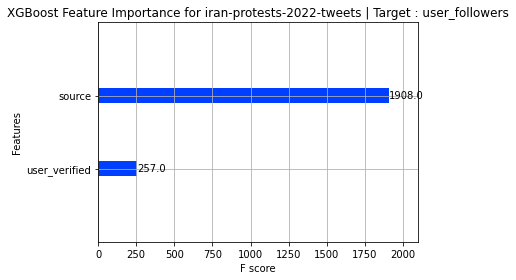

<Figure size 432x288 with 0 Axes>

In [26]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

         feature  importance
0         source      499.00
0  user_verified      389.00
1         source     1502.00
0  user_verified      257.00
1         source     1908.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

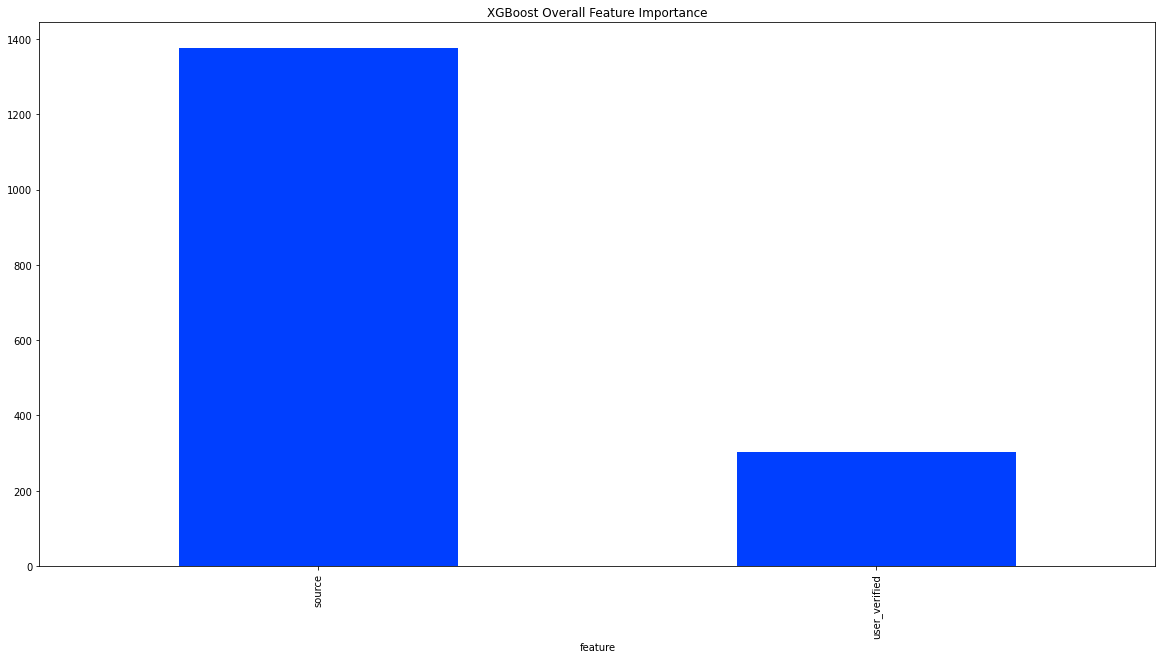

In [27]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [28]:
df.isna().sum()

user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
first_hashtag       0
dtype: int64

# **To Be Continued...**